In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('/home/user/Documents/10/Assignment/week-0/src')
print(rpath)
if rpath not in sys.path:
    sys.path.insert(0, rpath)

# print(src.loader)
from loader import SlackDataLoader
import utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [ ]:
def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [ ]:
def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict


In [ ]:





def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()




## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [136]:
read_file = SlackDataLoader("../anonymized")
data = read_file.slack_parser("../anonymized/all-week8/")

In [ ]:
data_path = "../anonymized/all-week9"
absolute_path = os.path.abspath(data_path)
print(absolute_path)


In [143]:
#which user has the highest number of reply counts?
grouped_data = data.groupby('user')['reply_count'].sum()
user_with_highest_replies = grouped_data.idxmax()
user_with_highest_replies

'U03V6HMRPGQ'

In [ ]:
# Visualize reply counts per user per channel
#read_file.draw_avg_reply_count(data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


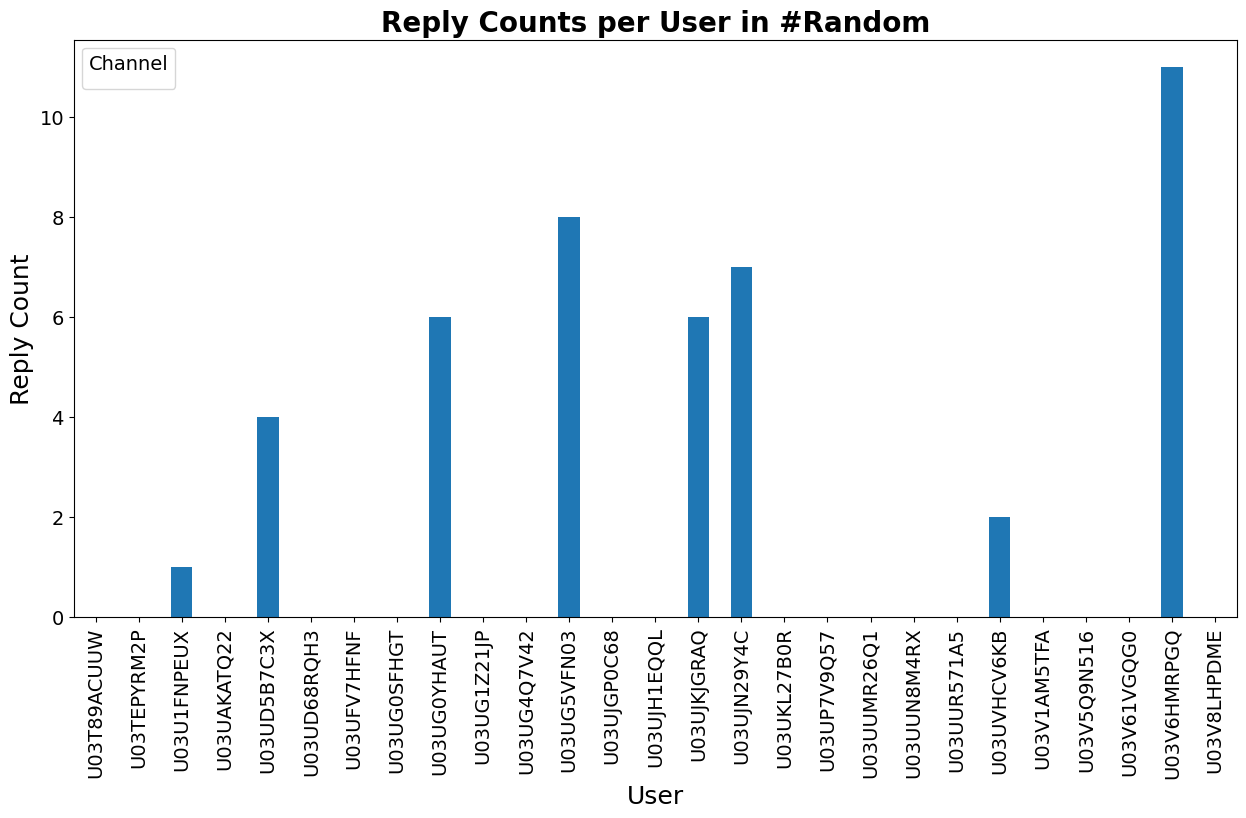

In [144]:
# Visualize reply counts per user per channel
read_file.visualize_reply_counts(data)

In [145]:
# what is the time range of the day that most messages are sent?
# Convert timestamp 
converted_time =  utils.convert_2_timestamp('msg_sent_time', data)

df = pd.DataFrame({'timestamp': converted_time})

# Extract the hour from the timestamp
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# Count the number of messages sent in each hour
hourly_counts = df['hour'].value_counts()

# Find the hour(s) with the highest message counts
most_active_hours = hourly_counts[hourly_counts == hourly_counts.max()]

# Print the time range of the most active hour(s)
start_hour = most_active_hours.index.min()
end_hour = most_active_hours.index.max()


print(f"from {start_hour} to {end_hour + 1}")

from 17 to 18


In [ ]:
# what kind of messages are replied faster than others?

In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

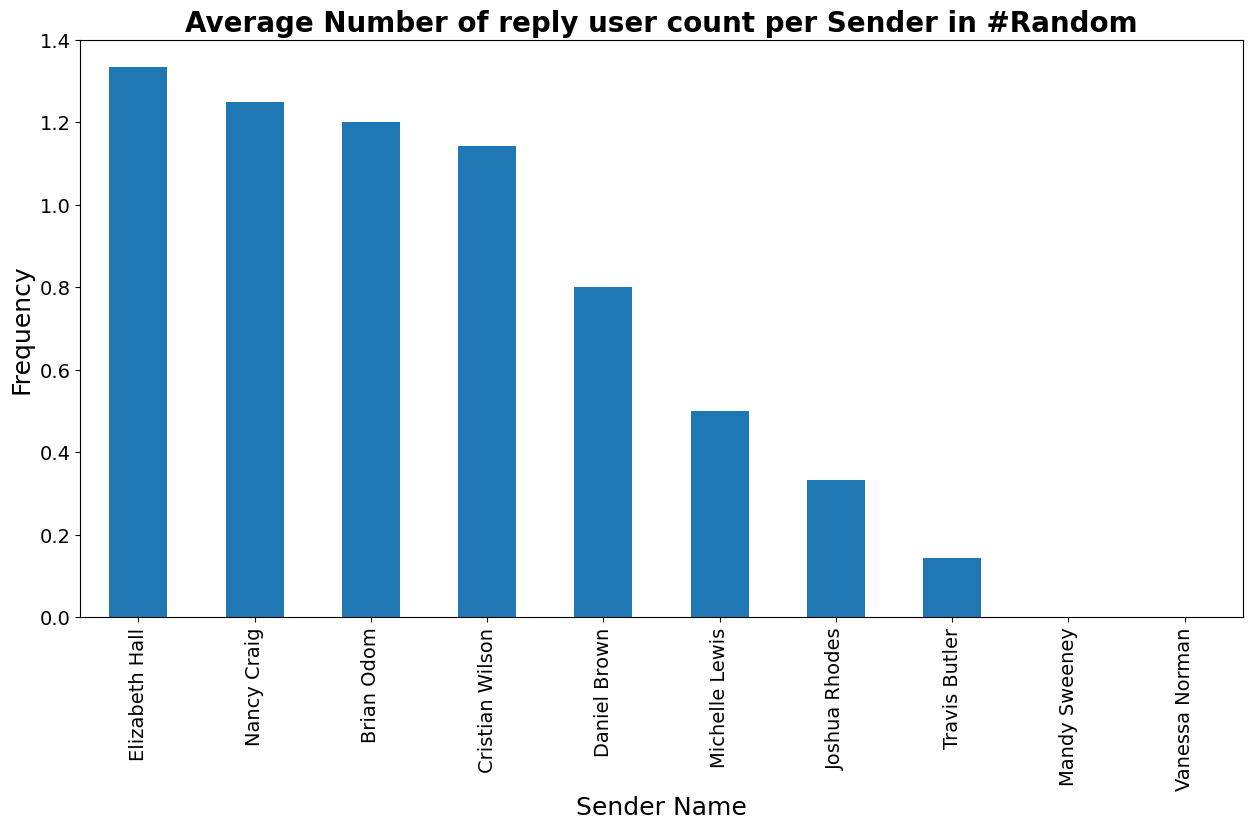

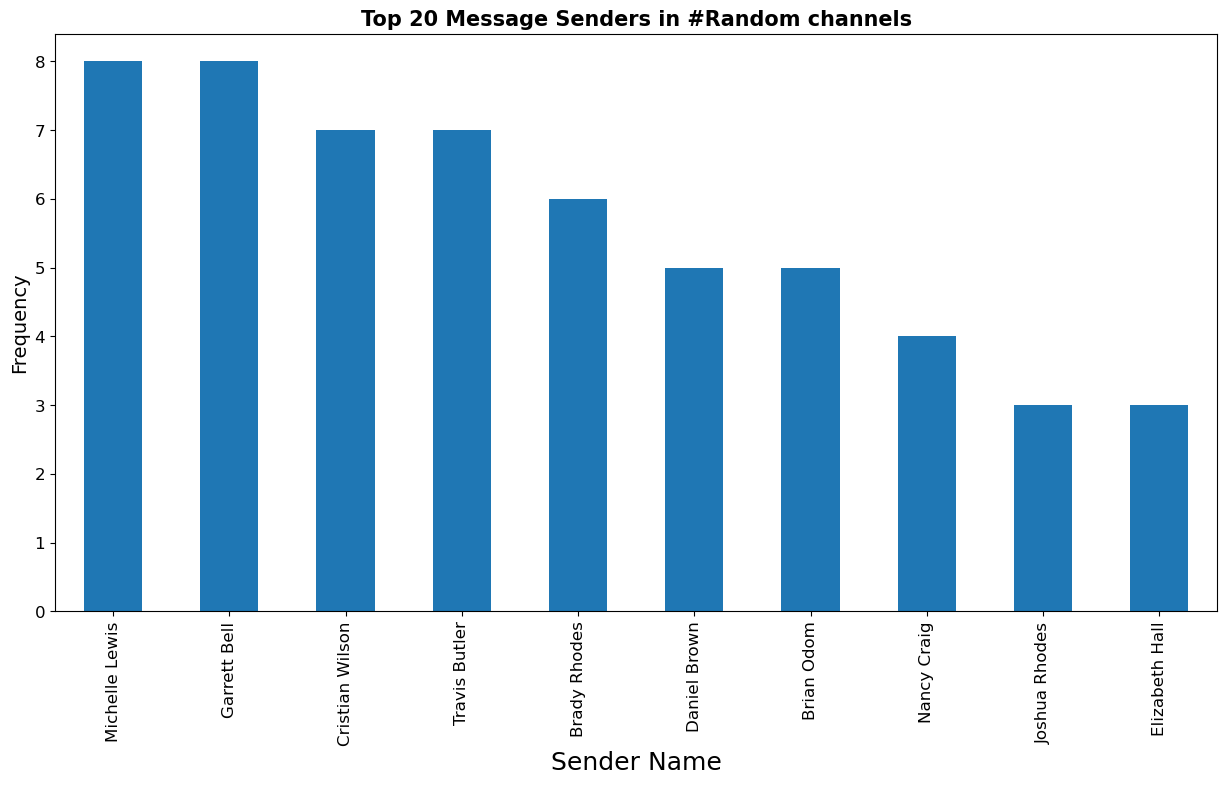

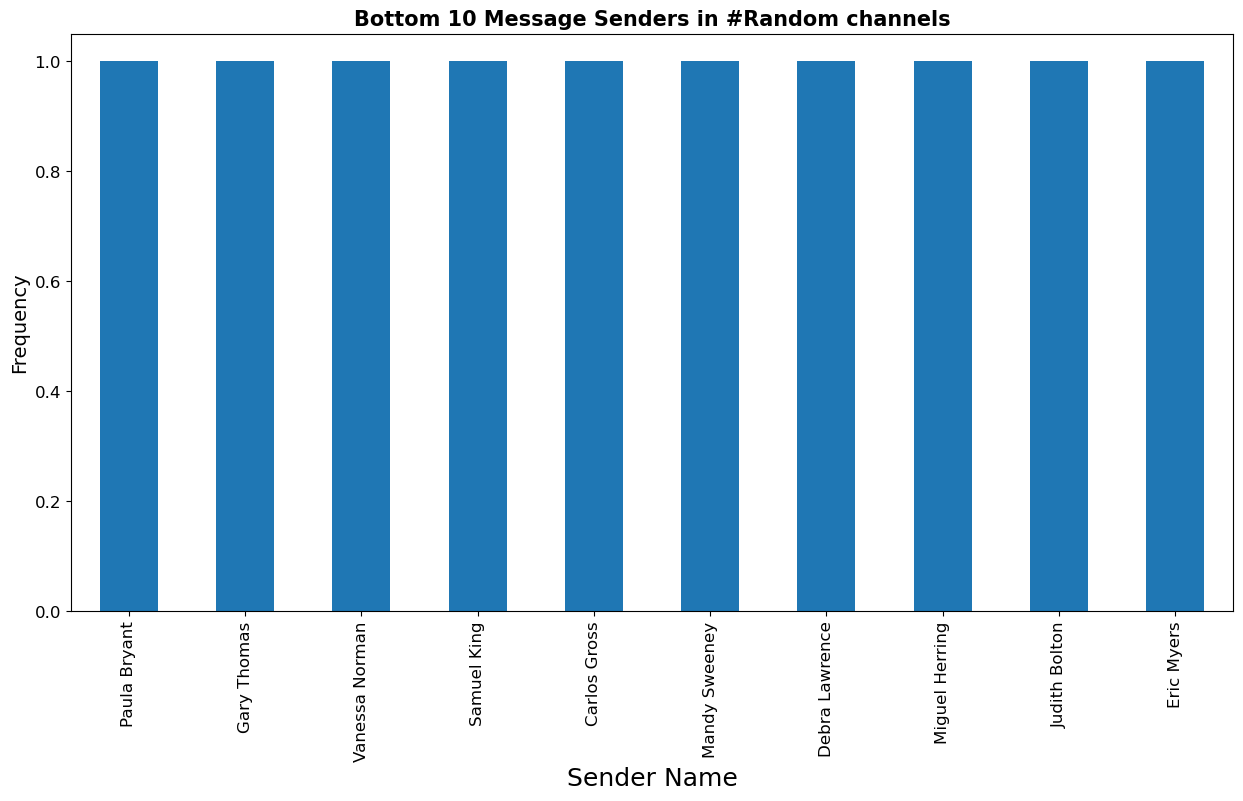

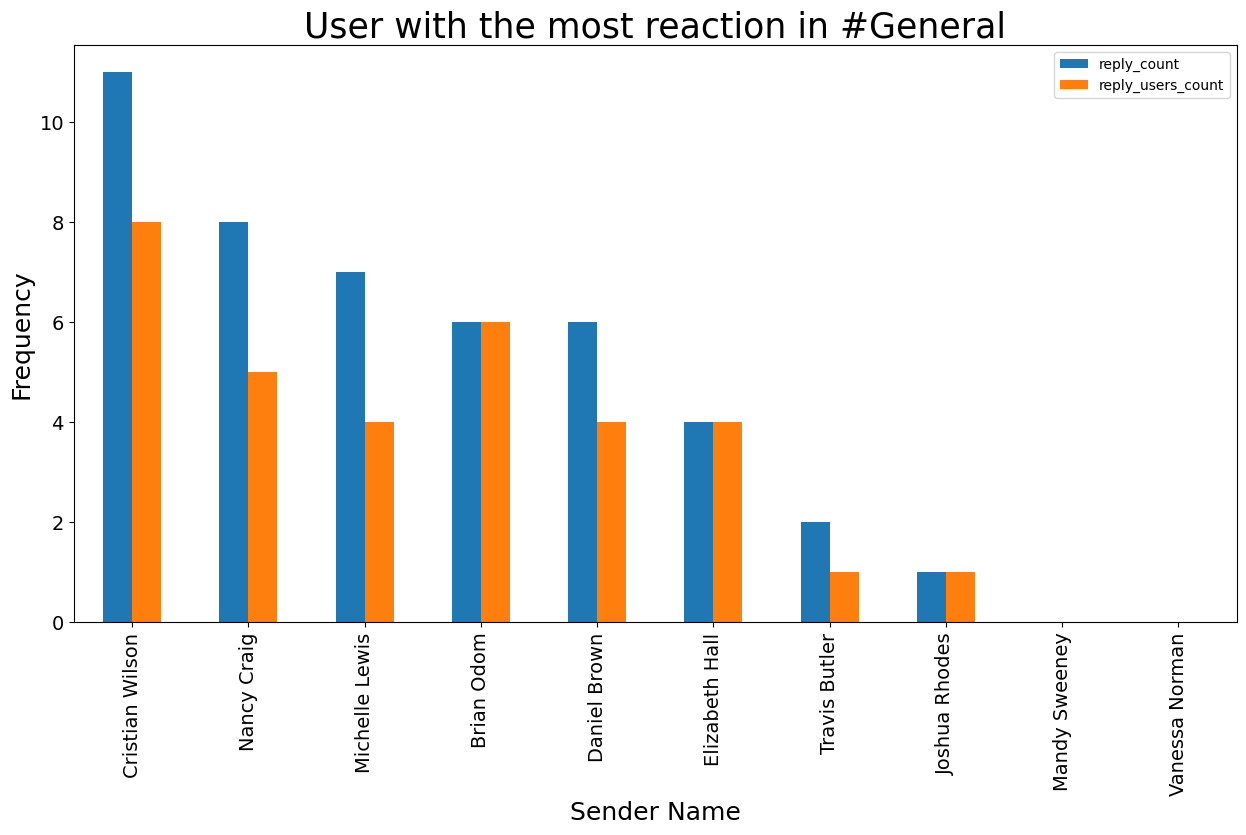

In [155]:
#Who are the top and bottom 10  users by 
#Reply count?
read_file.draw_avg_reply_users_count(data)
#Mention?

#Message count?
read_file.get_top_20_user(data)
#Reaction count?
read_file.draw_user_reaction(data)



In [173]:
#What are the top 10 messages by 

#Replies?

# Sort the DataFrame by reply_users_count in descending order
sorted_df = data.sort_values('reply_users_count', ascending=False)

# Get the top 10 rows with highest reply_users_count
top_10_counts = sorted_df.head(10)[['msg_content', 'reply_users_count']]

top_10_counts





#Mentions?



,msg_content,reply_users_count
8,can i get a recorded tutorial of today’s back...,5
14,During reading I witness a term (Security) in ...,5
72,When is the second tutorial scheduled for today,4
38,"hi, i just want to confirm that the submission...",3
34,Has the session ended? I lost connection and I...,3
49,"when cloning a repo, what's the difference bet...",3
66,can any one help me how to define dates in Pos...,2
40,<@U03UUN8M4RX> In answering my question you sa...,2
6,website from the current session (database des...,1
32,How do We get the k-line data guys? there are ...,1


In [174]:
#What are the top 10 messages by 
#Reactions?
reactions = parse_slack_reaction('../anonymized/all-week8/','random')

# Sort the DataFrame by reaction_count in descending order
sorted_df = reactions.sort_values('reaction_count', ascending=False)

# Get the top 10 reactions with highest reaction_count
top_10_reactions = sorted_df.head(10)

# Display the top 10 reactions
top_10_reactions[['reaction_name', 'reaction_count']]

,reaction_name,reaction_count
9,raised_hands,10
12,flushed,6
25,+1,6
23,+1,5
31,white_check_mark,4
14,smile,4
2,white_check_mark,3
20,raised_hands,3
8,+1,3
28,raised_hands,2


### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?